In [172]:
!pip install scikit-learn==0.23

In [173]:
!pip install imbalanced-learn==0.7.0

In [174]:
!pip install -q -U keras-tuner

In [175]:
!pip install pycaret==2.1.2

In [176]:
!pip install shap

In [6]:
from google.colab import files
uploaded = files.upload()

Saving aug_train.csv to aug_train.csv


<br>
<br>

# Preprocessing_01

<b>Column</b>
- **enrollee_id** >>> Delete

<b>Null</b>
- **experience** >>> Delete
- **enrolled_university** >>> Delete
- **last_new_job** >>> Delete
- **education_level** >>> Delete
- **company_type** >>> Unknown
- **major_discipline** >>> Unknown
- **gender** >>> Unknown

<b>Change</b>
- **experience** : <1 >>> 0
- **experience** : >20 >>> 20
- **last_new_job** : never >>> 0
- **last_new_job** : >4 >>> 5

In [7]:
import numpy as np
import pandas as pd

In [8]:
# load Data

df = pd.read_csv('aug_train.csv')


In [9]:
# Delete

df.drop(['enrollee_id'], axis=1, inplace=True)
df.dropna(subset=["experience"], inplace=True)
df.dropna(subset=["enrolled_university"], inplace=True)
df.dropna(subset=["last_new_job"], inplace=True)
df.dropna(subset=["education_level"], inplace=True)


In [10]:
# Replace

df['company_type'].fillna('Unknown',inplace=True)
df['major_discipline'].fillna('Unknown',inplace=True)
df['gender'].fillna('Unknown',inplace=True)


In [11]:
# Chage to int

df['experience'] = df['experience'].apply(lambda x: '0' if x == '<1' else x)
df['experience'] = df['experience'].apply(lambda x: '20' if x == '>20' else x)
df['experience'] = df['experience'].astype(int)


In [12]:
# Chage to int

df['last_new_job'] = df['last_new_job'].apply(lambda x: '0' if x == 'never' else x)
df['last_new_job'] = df['last_new_job'].apply(lambda x: '5' if x == '>4' else x)
df['last_new_job'] = df['last_new_job'].astype(int)


<br>
<br>

# Data Visualization_01
- **Imbalanced Data**

In [13]:
import matplotlib.pyplot as plt

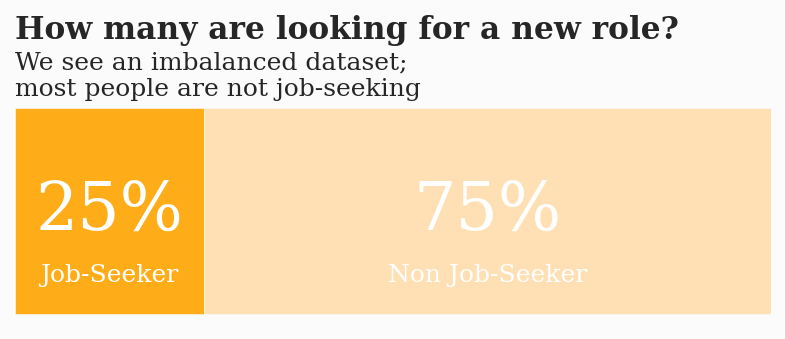

In [251]:

x = df.groupby(['target'])['target'].count()
y = len(df)
r = ((x/y)).round(2)
ratio = pd.DataFrame(r).T
# DataFrame().T == Transpose index and columns

fig, ax = plt.subplots(1,1,figsize=(6.5, 2),dpi=150)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color) 

ax.barh(ratio.index, ratio[1.0], color='orange', alpha=0.9, ec=background_color, label='Job-Seeker')
ax.barh(ratio.index, ratio[0.0], left=ratio[1.0], color='navajowhite', alpha=0.9,ec=background_color, label='Non Job-Seeker')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.legend().set_visible(False)

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
for i in ratio.index:
    ax.annotate(f"{int(ratio[1.0][i]*100)}%", xy=(ratio[1.0][i]/2, i), va='center',
                ha='center', fontsize=32, fontweight='light', fontfamily='serif', color='white')
    ax.annotate("Job-Seeker", xy=(ratio[1.0][i]/2, -0.25), va='center',
                ha='center', fontsize=12, fontweight='light', fontfamily='serif', color='white')
    
for i in ratio.index:
    ax.annotate(f"{int(ratio[0.0][i]*100)}%", xy=(ratio[1.0][i]+ratio[0.0][i]/2, i), va ='center',
                ha='center',fontsize=32, fontweight='light', fontfamily='serif', color='white')
    ax.annotate("Non Job-Seeker", xy=(ratio[1.0][i]+ratio[0.0][i]/2, -0.25), va ='center',
                ha='center',fontsize=12, fontweight='light', fontfamily='serif', color='white')

fig.text(0.125,1.075, 'How many are looking for a new role?', fontfamily='serif', fontsize=15, fontweight='bold')
fig.text(0.125,0.885, 'We see an imbalanced dataset;\nmost people are not job-seeking', fontfamily='serif', fontsize=12)  

plt.show()


<br>
<br>

# Preprocessing_02

<b>Null</b>
- **company_size** >>> KNNImputer

In [15]:
# LabelEncoder 적용 전, company_size 칼럼의 데이터들을 str로 통일

df['company_size'].fillna('0', inplace=True)


In [16]:
# df 확인

df.head()


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20,0,Unknown,1,36,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,5,47,0.0
2,city_21,0.624,Unknown,No relevent experience,Full time course,Graduate,STEM,5,0,Unknown,0,83,0.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,20,50-99,Funded Startup,4,8,0.0
5,city_176,0.764,Unknown,Has relevent experience,Part time course,Graduate,STEM,11,0,Unknown,1,24,1.0


In [17]:
# install scikit-learn

# !pip install scikit-learn==0.23


In [18]:
# import LabelEncoder

from sklearn.preprocessing import LabelEncoder


In [19]:
# LabelEncoder를 적용할 새로운 데이터프레임을 df_lb으로 생성

df_lb = df.copy()


In [20]:
# LabelEncoder를 적용할 데이터는 object타입의 데이터이므로 해당 데이터들을 가진 칼럼 추출

transform_list = list(df_lb.select_dtypes(include=[object]).columns)
transform_list


['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'company_size',
 'company_type']

In [21]:
# LabelEncoder를 fit할 칼럼별 각각의 LabelEncoder 생성

for i, value in enumerate(transform_list):
    globals()['LabelEncoder_{}'.format(i)] = LabelEncoder()
    print('LabelEncoder_'+str(i)+' : '+value)
    

LabelEncoder_0 : city
LabelEncoder_1 : gender
LabelEncoder_2 : relevent_experience
LabelEncoder_3 : enrolled_university
LabelEncoder_4 : education_level
LabelEncoder_5 : major_discipline
LabelEncoder_6 : company_size
LabelEncoder_7 : company_type


In [22]:
# 만들어진 LabelEncoder들을 리스트로 묶음

lb_list = [LabelEncoder_0, LabelEncoder_1, LabelEncoder_2, LabelEncoder_3,
           LabelEncoder_4, LabelEncoder_5, LabelEncoder_6, LabelEncoder_7]


In [23]:
# 각각의 LabelEncoder에 대해 transform 진행

for i, value in enumerate(lb_list):
    value.fit(df_lb[str(transform_list[i])])
    df_lb[str(transform_list[i])] = value.transform(df_lb[str(transform_list[i])])
    

In [24]:
# df_lb 확인

df_lb.head()


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,5,0.920,1,0,2,0,5,20,0,6,1,36,1.0
1,77,0.776,1,1,2,0,5,15,5,5,5,47,0.0
2,64,0.624,3,1,0,0,5,5,0,6,0,83,0.0
4,50,0.767,1,0,2,2,5,20,5,1,4,8,0.0
5,57,0.764,3,0,1,0,5,11,0,6,1,24,1.0


In [25]:
# company_size에 LabelEncoder가 적용된 결과로 0이 된 데이터를 다시 NaN으로 변경

df_lb['company_size'].replace(0, np.nan, inplace=True)


In [26]:
# df_lb 확인

df_lb.head()


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,5,0.920,1,0,2,0,5,20,NaN,6,1,36,1.0
1,77,0.776,1,1,2,0,5,15,5.0,5,5,47,0.0
2,64,0.624,3,1,0,0,5,5,NaN,6,0,83,0.0
4,50,0.767,1,0,2,2,5,20,5.0,1,4,8,0.0
5,57,0.764,3,0,1,0,5,11,NaN,6,1,24,1.0


In [27]:
# df_lb 확인

df_lb.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18014 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    18014 non-null  int64  
 1   city_development_index  18014 non-null  float64
 2   gender                  18014 non-null  int64  
 3   relevent_experience     18014 non-null  int64  
 4   enrolled_university     18014 non-null  int64  
 5   education_level         18014 non-null  int64  
 6   major_discipline        18014 non-null  int64  
 7   experience              18014 non-null  int64  
 8   company_size            12704 non-null  float64
 9   company_type            18014 non-null  int64  
 10  last_new_job            18014 non-null  int64  
 11  training_hours          18014 non-null  int64  
 12  target                  18014 non-null  float64
dtypes: float64(3), int64(10)
memory usage: 1.9 MB


In [28]:
# import KNNImputer

from sklearn.impute import KNNImputer


In [29]:
# imputer 정의

imputer = KNNImputer(n_neighbors=5)


In [30]:
# KNNImputer의 fit_transform을 df_lb에 적용
# df_im로 데이터프레임명 지정

df_im = imputer.fit_transform(df_lb)


In [31]:
# df_im 확인

df_im


array([[  5.   ,   0.92 ,   1.   , ...,   1.   ,  36.   ,   1.   ],
       [ 77.   ,   0.776,   1.   , ...,   5.   ,  47.   ,   0.   ],
       [ 64.   ,   0.624,   3.   , ...,   0.   ,  83.   ,   0.   ],
       ...,
       [  5.   ,   0.92 ,   1.   , ...,   4.   ,  44.   ,   0.   ],
       [ 94.   ,   0.802,   1.   , ...,   2.   ,  97.   ,   0.   ],
       [ 95.   ,   0.855,   3.   , ...,   1.   , 127.   ,   0.   ]])

In [32]:
# numpy array인 df_im을 데이터프레임으로 변경

df_im = pd.DataFrame(df_im)


In [33]:
# KNNImputer가 적용된 company_size를 반올림하여 기존 LabelEncoder 규칙을 가진 값으로 변경

df_im[9] = df_im[9].round()


In [34]:
# df_im의 데이터들을 LabelEncoder의 규칙에 맞게 df_lb가 가진 데이터타입으로 변경

for i in range(len(df_im.columns)):
    df_im[i] = df_im[i].astype(df_lb.dtypes[i])
    

In [35]:
# df_im의 칼럼명들을 LabelEncoder의 규칙에 맞게 df_lb가 가진 칼럼명으로 변경

for i in range(len(df_im.columns)):
    df_im.rename(columns = {i : list(df_lb.columns)[i]}, inplace = True)
    

In [36]:
# df_im 확인

df_im.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18014 entries, 0 to 18013
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    18014 non-null  int64  
 1   city_development_index  18014 non-null  float64
 2   gender                  18014 non-null  int64  
 3   relevent_experience     18014 non-null  int64  
 4   enrolled_university     18014 non-null  int64  
 5   education_level         18014 non-null  int64  
 6   major_discipline        18014 non-null  int64  
 7   experience              18014 non-null  int64  
 8   company_size            18014 non-null  float64
 9   company_type            18014 non-null  int64  
 10  last_new_job            18014 non-null  int64  
 11  training_hours          18014 non-null  int64  
 12  target                  18014 non-null  float64
dtypes: float64(3), int64(10)
memory usage: 1.8 MB


In [37]:
# 칼럼 company_size의 데이터가 제대로 바뀌지 않고 float64로 남아있기 때문에 다시 df_lb와 같은 int32타입으로 변경 

df_im['company_size'] = df_im['company_size'].astype('int32')


In [38]:
# df_im 확인

df_im.head()


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,5,0.920,1,0,2,0,5,20,4,6,1,36,1.0
1,77,0.776,1,1,2,0,5,15,5,5,5,47,0.0
2,64,0.624,3,1,0,0,5,5,4,6,0,83,0.0
3,50,0.767,1,0,2,2,5,20,5,1,4,8,0.0
4,57,0.764,3,0,1,0,5,11,2,6,1,24,1.0


In [39]:
# df_im 확인

df_im.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18014 entries, 0 to 18013
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    18014 non-null  int64  
 1   city_development_index  18014 non-null  float64
 2   gender                  18014 non-null  int64  
 3   relevent_experience     18014 non-null  int64  
 4   enrolled_university     18014 non-null  int64  
 5   education_level         18014 non-null  int64  
 6   major_discipline        18014 non-null  int64  
 7   experience              18014 non-null  int64  
 8   company_size            18014 non-null  int32  
 9   company_type            18014 non-null  int64  
 10  last_new_job            18014 non-null  int64  
 11  training_hours          18014 non-null  int64  
 12  target                  18014 non-null  float64
dtypes: float64(2), int32(1), int64(10)
memory usage: 1.7 MB


<br>
<br>

#Machine Learning_01

<b>Scikit-learn</b>
- **train_test_split**
- **Pipeline**

<b>imbalanced-learn</b>
- **SMOTE**

<b>TensorFlow</b>
- **Deep Learning**
- **kears tuner**

In [40]:
# import train_test_split

from sklearn.model_selection import train_test_split


In [50]:
# train_test_split 실행

X = df_im.drop('target', axis=1)
y = df_im['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


In [51]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [52]:
df_im.columns

Index(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target'],
      dtype='object')

In [53]:
numeric_features = ['city_development_index', 'experience','last_new_job', 'training_hours']
numeric_transformer = MinMaxScaler()

categorical_features = ['city', 'gender', 'relevent_experience', 'enrolled_university',
                        'education_level', 'major_discipline', 'company_size', 'company_type']
categorical_transformer = OneHotEncoder(categories='auto') # categories='auto' : just for ignoring warning messages

preprocessor = ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocessor_pipe = Pipeline(steps=[('ColumnTransform', preprocessor)])

In [54]:
preprocessor_pipe.fit(X_train)

Pipeline(steps=[('ColumnTransform',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['city_development_index',
                                                   'experience', 'last_new_job',
                                                   'training_hours']),
                                                 ('cat', OneHotEncoder(),
                                                  ['city', 'gender',
                                                   'relevent_experience',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline',
                                                   'company_size',
                                                   'company_type'])]))])

In [55]:
X_train_transformed = preprocessor_pipe.transform(X_train)
X_test_transformed = preprocessor_pipe.transform(X_test)

In [57]:
X_train_transformed.shape

(12609, 163)

In [66]:
X_test_transformed.shape

(5405, 163)

In [64]:
pd.DataFrame.sparse.from_spmatrix(X_train_transformed).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162
0,0.942116,0.05,0.2,0.011940,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.942116,0.15,0.0,0.128358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.710579,1.00,1.0,0.047761,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.858283,0.15,0.2,0.131343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.882236,0.40,1.0,0.104478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [65]:
pd.DataFrame.sparse.from_spmatrix(X_test_transformed).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162
0,0.626747,1.00,1.0,0.041791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.812375,0.20,0.2,0.701493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.942116,0.55,0.6,0.337313,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.203593,0.35,0.2,0.164179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.942116,0.40,0.4,0.635821,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [67]:
# install imbalanced-learn

# !pip install imbalanced-learn==0.7.0


In [68]:
# import SMOTE

from imblearn.over_sampling import SMOTE


In [111]:
# X_train_copy와 y_train을 y_train(target)의 클래스 비율을 동일하게 하는 방식으로 SMOTE 실행

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train_transformed, y_train)


In [112]:
# y_train_over을 model의 label로 넣기 위해 array.reshape(-1, 1) 진행

y_train_over = np.array(y_train_over)
y_train_over = y_train_over.reshape(-1, 1)


In [113]:
# y_test를 model의 label로 넣기 위해 array.reshape(-1, 1) 진행

y_test = np.array(y_test)
y_test = y_test.reshape(-1, 1)


In [114]:
# import OneHotEncoder

# from sklearn.preprocessing import OneHotEncoder


In [115]:
# OneHotEncoder

enc = OneHotEncoder(categories='auto')
enc.fit(y_train_over)
train_label = enc.transform(y_train_over).toarray()
test_label = enc.transform(y_test).toarray()


In [116]:
# import tensorflow

from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics


In [117]:
# model 생성

model = models.Sequential()

model.add(layers.Dense(input_dim=163, units=256, activation=None, kernel_initializer=initializers.he_uniform()))
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(units=2, activation='softmax'))


In [118]:
# model compile

model.compile(optimizer=optimizers.Adam(),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy,
                       metrics.Precision(),
                       metrics.Recall(),
                       metrics.FalsePositives(),
                       metrics.FalseNegatives()])


In [119]:
type(X_train_over)

scipy.sparse.csr.csr_matrix

In [127]:
from scipy import sparse

In [128]:
X_train_over = sparse.csr_matrix.toarray(X_train_over)

In [129]:
type(X_train_over)

numpy.ndarray

In [130]:
X_train_over.shape

(19028, 163)

In [131]:
train_label.shape

(19028, 2)

In [134]:

history = model.fit(X_train_over, train_label, batch_size=100, epochs=20, validation_split=0.3, verbose=1)


Epoch 1/20
134/134 [==============================] - 4s 19ms/step - loss: 0.7516 - categorical_accuracy: 0.7141 - precision_3: 0.7141 - recall_3: 0.7141 - false_positives_3: 1857.4519 - false_negatives_3: 1857.4519 - val_loss: 1.1190 - val_categorical_accuracy: 0.3428 - val_precision_3: 0.3428 - val_recall_3: 0.3428 - val_false_positives_3: 3752.0000 - val_false_negatives_3: 3752.0000
Epoch 2/20
134/134 [==============================] - 2s 15ms/step - loss: 0.5269 - categorical_accuracy: 0.7564 - precision_3: 0.7564 - recall_3: 0.7564 - false_positives_3: 1663.2222 - false_negatives_3: 1663.2222 - val_loss: 1.0047 - val_categorical_accuracy: 0.4680 - val_precision_3: 0.4680 - val_recall_3: 0.4680 - val_false_positives_3: 3037.0000 - val_false_negatives_3: 3037.0000
Epoch 3/20
134/134 [==============================] - 2s 14ms/step - loss: 0.4852 - categorical_accuracy: 0.7756 - precision_3: 0.7756 - recall_3: 0.7756 - false_positives_3: 1547.9778 - false_negatives_3: 1547.9778 - val_

In [136]:
# model evaluate
# F1 Score = 2*(Recall * Precision) / (Recall + Precision)

_loss, _acc, _precision, _recall, _false_positives, _false_negatives = model.evaluate(X_test_transformed, test_label)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, F1 Score: {:.3f}, false positives: {:.3f}, false negatives: {:.3f}'
      .format(_loss, _acc, _precision, _recall, 2*(_recall*_precision)/(_recall+_precision), _false_positives, _false_negatives))


169/169 [==============================] - 1s 5ms/step - loss: 0.4674 - categorical_accuracy: 0.7895 - precision_3: 0.7895 - recall_3: 0.7895 - false_positives_3: 1138.0000 - false_negatives_3: 1138.0000
loss: 0.467, accuracy: 0.789, precision: 0.789, recall: 0.789, F1 Score: 0.789, false positives: 1138.000, false negatives: 1138.000


In [140]:
y_pred = model.predict(X_test_transformed)
y_pred = (y_pred > 0.5)

In [142]:
from sklearn.metrics import classification_report

In [143]:
print(classification_report(test_label, y_pred, target_names=['normal', 'abnormal']))

              precision    recall  f1-score   support

      normal       0.85      0.88      0.86      4079
    abnormal       0.58      0.52      0.55      1326

   micro avg       0.79      0.79      0.79      5405
   macro avg       0.71      0.70      0.70      5405
weighted avg       0.78      0.79      0.79      5405
 samples avg       0.79      0.79      0.79      5405



In [137]:

history.history.keys()


dict_keys(['loss', 'categorical_accuracy', 'precision_3', 'recall_3', 'false_positives_3', 'false_negatives_3', 'val_loss', 'val_categorical_accuracy', 'val_precision_3', 'val_recall_3', 'val_false_positives_3', 'val_false_negatives_3'])

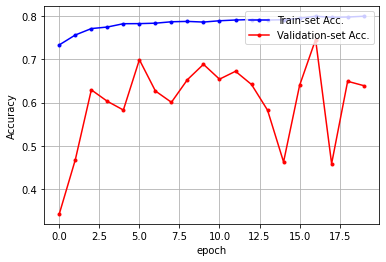

In [138]:
# Accuracy 시각화

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()


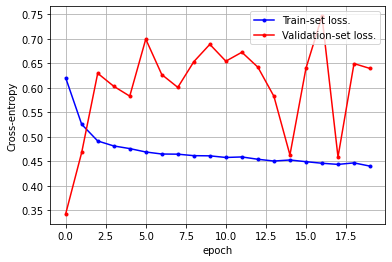

In [139]:
# loss(==Cross-entropy) 시각화

loss = history.history['loss']
val_loss = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()


In [144]:
# install keras-tuner

# !pip install -q -U keras-tuner


In [145]:
# import tensorflow & kerastuner

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow import keras 
# from tensorflow.keras import layers

import kerastuner as kt

# import IPython

In [147]:
# Build the hyper-model

def build_hyper_model(hp):
    
    model = keras.Sequential()
        
    # Tune the number of hidden layer (Choose an optimal value between 1~3)
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)): 
        # Tune the number of perceptrons in a dense layer (Choose an optimal value between 32~512) 
        hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32) # 32:512 & step 32, all parameter names should be unique (we name the inner parameters 'units_' + str(i))
        hp_activations = hp.Choice('activation_' + str(i), values=['relu', 'elu']) # relu & elu
        model.add(layers.Dense(units=hp_units, activation=hp_activations))

    model.add(layers.Dense(2, activation='softmax'))

    # Tune the learning rate for the optimizer (Choose an optimal value from 0.01, 0.001, or 0.0001)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) 
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model
    

In [148]:
# Select tuner and compile it

tuner = kt.BayesianOptimization(build_hyper_model,
                                objective='val_accuracy', # Hyper-params tuning을 위한 목적함수 설정 (metric to minimize or maximize)
                                max_trials=10, # 서로 다른 Hyper-params 조합으로 시도할 총 Trial 횟수 설정
                                directory='test_prac_dir', # Path to the working directory
                                project_name='jobseeker_hyper_01') # Name to use as directory name for files saved by this Tuner

tuner.search_space_summary()


Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [149]:
# Train the model

tuner.search(X_train_over, train_label, epochs=10, validation_data=(X_test_transformed, test_label)) # epochs == learning epoch for training a single model(epoch for each trial) 


# # 아래와 같이 별도의 클래스로 콜백을 정의하여 search 함수에서 활용하면 모든 학습 단계 종료 후 학습 중 발생한 출력 결과를 자동으로 지워낼 수 있습니다.
# class ClearTrainingOutput(tf.keras.callbacks.Callback):
#   def on_train_end(*args, **kwargs):
#     IPython.display.clear_output(wait = True)

Trial 10 Complete [00h 00m 10s]
val_accuracy: 0.7864940166473389

Best val_accuracy So Far: 0.7920444011688232
Total elapsed time: 00h 02m 29s


In [150]:
# Check the result 

tuner.results_summary(num_trials=1) # Show "n" best trial results


Results summary
Results in test_prac_dir/jobseeker_hyper_01
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 3
units_0: 448
activation_0: relu
learning_rate: 0.0001
units_1: 32
activation_1: relu
units_2: 32
activation_2: relu
Score: 0.7920444011688232


<br>
<br>

#Machine Learning_02

<b>PyCaret</b>
- **compare_models**
- **tune_model**
- **blend_models**

In [ ]:
# !pip install pycaret==2.1.2

In [151]:
from pycaret.classification import *

In [152]:
df_im.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,5,0.920,1,0,2,0,5,20,4,6,1,36,1.0
1,77,0.776,1,1,2,0,5,15,5,5,5,47,0.0
2,64,0.624,3,1,0,0,5,5,4,6,0,83,0.0
3,50,0.767,1,0,2,2,5,20,5,1,4,8,0.0
4,57,0.764,3,0,1,0,5,11,2,6,1,24,1.0


In [153]:
df_im['target'] = df_im['target'].astype(int)

In [154]:
data = df_im.sample(frac=0.7, random_state=786).reset_index(drop=True)
data_unseen = df_im.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (12610, 13)
Unseen Data For Predictions: (5404, 13)


In [156]:
model = setup(data=data,
              target='target',
              categorical_features=['city', 'gender', 'relevent_experience', 'enrolled_university',
                                    'education_level', 'major_discipline', 'company_size', 'company_type'],
              numeric_features=['city_development_index', 'experience','last_new_job', 'training_hours'],
              fix_imbalance=True,
              session_id=123)

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(12610, 13)"
4,Missing Values,False
5,Numeric Features,4
6,Categorical Features,8
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [157]:
top_3_models = compare_models(sort='Accuracy',
                              n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.7879,0.7865,0.5123,0.5748,0.5415,0.4042,0.4055,3.2175
1,Gradient Boosting Classifier,0.7871,0.7859,0.5215,0.5714,0.5450,0.4065,0.4074,4.7492
2,Ada Boost Classifier,0.7844,0.7784,0.4697,0.5729,0.5157,0.3789,0.3823,1.4633
3,CatBoost Classifier,0.7843,0.7831,0.4974,0.5675,0.5299,0.3908,0.3924,20.6545
4,Light Gradient Boosting Machine,0.7811,0.7808,0.4743,0.5628,0.5146,0.3747,0.3770,0.6939
5,Extra Trees Classifier,0.7659,0.7415,0.4137,0.5277,0.4634,0.3167,0.3207,2.0730
6,Random Forest Classifier,0.7655,0.7359,0.3521,0.5326,0.4235,0.2840,0.2938,0.2164
7,Ridge Classifier,0.7642,0.0000,0.6973,0.5134,0.5911,0.4308,0.4411,0.0524
8,Linear Discriminant Analysis,0.7639,0.7829,0.6964,0.5129,0.5905,0.4299,0.4401,0.4036
9,Logistic Regression,0.7593,0.7826,0.7084,0.5063,0.5900,0.4264,0.4390,0.5186


In [160]:
xgb = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7712,0.7439,0.4630,0.5376,0.4975,0.3505,0.3521
1,0.7984,0.7885,0.5417,0.5969,0.5680,0.4369,0.4378
2,0.7984,0.8220,0.5556,0.5941,0.5742,0.4423,0.4427
3,0.7848,0.7927,0.4815,0.5714,0.5226,0.3850,0.3874
4,0.7928,0.7698,0.4954,0.5912,0.5390,0.4067,0.4093
5,0.7905,0.8150,0.5392,0.5792,0.5585,0.4214,0.4218
6,0.7925,0.7760,0.5370,0.5829,0.5590,0.4237,0.4243
7,0.7925,0.8011,0.5370,0.5829,0.5590,0.4237,0.4243
8,0.7823,0.7649,0.4769,0.5659,0.5176,0.3784,0.3807
9,0.7755,0.7910,0.4954,0.5459,0.5194,0.3734,0.3742


In [161]:
tuned_xgb = tune_model(xgb, optimize='Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7644,0.7353,0.4444,0.5217,0.4800,0.3290,0.3308
1,0.7882,0.7801,0.4722,0.5829,0.5217,0.3877,0.3912
2,0.7712,0.8039,0.4537,0.5385,0.4925,0.3462,0.3483
3,0.7769,0.7753,0.4352,0.5562,0.4883,0.3484,0.3527
4,0.7814,0.7558,0.4398,0.5689,0.4961,0.3594,0.3643
5,0.7939,0.7962,0.5714,0.5822,0.5767,0.4405,0.4406
6,0.8095,0.7859,0.5833,0.6176,0.6000,0.4751,0.4755
7,0.7925,0.8067,0.5093,0.5882,0.5459,0.4123,0.4141
8,0.7596,0.7530,0.4306,0.5110,0.4673,0.3136,0.3155
9,0.7585,0.7808,0.4398,0.5080,0.4715,0.3160,0.3174


In [158]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7758,0.7455,0.4722,0.5484,0.5075,0.3633,0.3650
1,0.7961,0.7857,0.5417,0.5909,0.5652,0.4324,0.4331
2,0.7894,0.8219,0.5509,0.5721,0.5613,0.4228,0.4229
3,0.7882,0.7916,0.5093,0.5759,0.5405,0.4036,0.4049
4,0.7916,0.7696,0.5000,0.5870,0.5400,0.4064,0.4086
5,0.7939,0.8122,0.5668,0.5829,0.5748,0.4388,0.4389
6,0.7925,0.7779,0.5278,0.5846,0.5547,0.4199,0.4209
7,0.7880,0.7981,0.5370,0.5714,0.5537,0.4148,0.4152
8,0.7766,0.7638,0.4722,0.5514,0.5087,0.3653,0.3671
9,0.7789,0.7931,0.5370,0.5498,0.5433,0.3975,0.3976


In [159]:
tuned_gbc = tune_model(gbc, optimize='Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7610,0.7328,0.4259,0.5140,0.4658,0.3137,0.3160
1,0.7928,0.7891,0.4907,0.5922,0.5367,0.4047,0.4077
2,0.7826,0.7991,0.4954,0.5632,0.5271,0.3867,0.3880
3,0.7826,0.7710,0.4676,0.5674,0.5127,0.3744,0.3773
4,0.7441,0.7452,0.3704,0.4706,0.4145,0.2537,0.2567
5,0.7814,0.7935,0.5253,0.5588,0.5416,0.3983,0.3986
6,0.8084,0.7860,0.5880,0.6135,0.6005,0.4745,0.4747
7,0.7902,0.8044,0.4815,0.5876,0.5293,0.3960,0.3993
8,0.7834,0.7795,0.4537,0.5731,0.5065,0.3701,0.3743
9,0.7710,0.7665,0.4676,0.5372,0.5000,0.3524,0.3538


In [169]:
adaboost = create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7712,0.7394,0.4259,0.5412,0.4767,0.3330,0.3369
1,0.7894,0.7825,0.5000,0.5806,0.5373,0.4019,0.4038
2,0.8075,0.8217,0.5370,0.6237,0.5771,0.4534,0.4555
3,0.7814,0.7912,0.4306,0.5706,0.4908,0.3551,0.3608
4,0.7826,0.7548,0.4213,0.5759,0.4866,0.3529,0.3598
5,0.7894,0.8125,0.5069,0.5820,0.5419,0.4060,0.4076
6,0.7868,0.7598,0.4769,0.5787,0.5228,0.3873,0.3903
7,0.7846,0.7894,0.4722,0.5730,0.5178,0.3807,0.3837
8,0.7891,0.7586,0.4630,0.5882,0.5181,0.3856,0.3901
9,0.7619,0.7743,0.4630,0.5155,0.4878,0.3333,0.3341


In [170]:
tuned_adaboost = tune_model(adaboost, optimize='Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7780,0.7442,0.4213,0.5617,0.4815,0.3439,0.3497
1,0.7894,0.7876,0.4769,0.5852,0.5255,0.3919,0.3953
2,0.7905,0.8241,0.5000,0.5838,0.5387,0.4042,0.4062
3,0.7735,0.7931,0.4306,0.5471,0.4819,0.3396,0.3435
4,0.7882,0.7688,0.4167,0.5960,0.4905,0.3620,0.3713
5,0.7848,0.8217,0.4839,0.5738,0.5250,0.3872,0.3896
6,0.7982,0.7724,0.5139,0.6033,0.5550,0.4256,0.4279
7,0.7857,0.7938,0.4630,0.5780,0.5141,0.3788,0.3827
8,0.7857,0.7658,0.4352,0.5839,0.4987,0.3661,0.3725
9,0.7642,0.7864,0.4306,0.5225,0.4721,0.3221,0.3246


In [162]:
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7712,0.7400,0.4676,0.5372,0.5000,0.3526,0.3540
1,0.7894,0.7898,0.5139,0.5781,0.5441,0.4078,0.4090
2,0.7871,0.8051,0.5093,0.5729,0.5392,0.4014,0.4026
3,0.7758,0.7844,0.4676,0.5489,0.5050,0.3612,0.3632
4,0.7735,0.7699,0.4537,0.5444,0.4949,0.3505,0.3529
5,0.7860,0.8066,0.5115,0.5722,0.5401,0.4012,0.4023
6,0.8050,0.7815,0.5648,0.6100,0.5865,0.4592,0.4598
7,0.7971,0.8054,0.5231,0.5979,0.5580,0.4271,0.4287
8,0.7800,0.7575,0.4537,0.5632,0.5026,0.3635,0.3670
9,0.7778,0.7910,0.5093,0.5500,0.5288,0.3837,0.3842


In [163]:
tuned_catboost = tune_model(catboost, optimize='Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7735,0.7470,0.4815,0.5417,0.5098,0.3632,0.3643
1,0.8018,0.7900,0.5648,0.6010,0.5823,0.4526,0.4530
2,0.7928,0.8274,0.5556,0.5797,0.5674,0.4312,0.4314
3,0.7837,0.7910,0.5046,0.5648,0.5330,0.3928,0.3939
4,0.7928,0.7691,0.5000,0.5902,0.5414,0.4087,0.4110
5,0.7860,0.8160,0.5438,0.5673,0.5553,0.4144,0.4146
6,0.8005,0.7798,0.5741,0.5962,0.5849,0.4536,0.4538
7,0.7937,0.8028,0.5556,0.5825,0.5687,0.4332,0.4334
8,0.7834,0.7696,0.4861,0.5676,0.5237,0.3846,0.3866
9,0.7812,0.7876,0.5093,0.5584,0.5327,0.3902,0.3909


In [165]:
evaluate_model(tuned_xgb)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [164]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [171]:
evaluate_model(tuned_adaboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [166]:
# !pip install shap

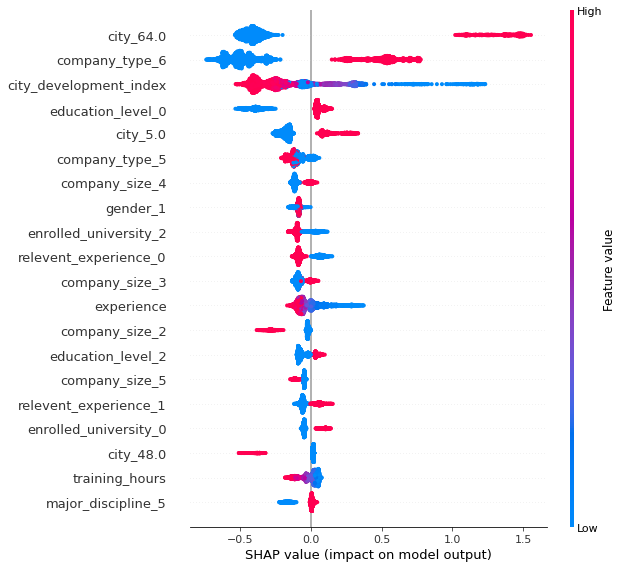

In [167]:
interpret_model(tuned_catboost)

In [168]:
blended = blend_models(estimator_list=top_3_models, 
                       fold=10,
                       optimize='Accuracy',
                       method = 'hard')

# method 'hard' : uses predicted class labels for majority rule voting.
# method 'soft' : predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7735,0.0000,0.4630,0.5435,0.5000,0.3548,0.3567
1,0.7928,0.0000,0.5370,0.5829,0.5590,0.4239,0.4245
2,0.7973,0.0000,0.5694,0.5885,0.5788,0.4454,0.4455
3,0.7894,0.0000,0.4954,0.5815,0.5350,0.4000,0.4021
4,0.7961,0.0000,0.5000,0.6000,0.5455,0.4155,0.4183
5,0.7882,0.0000,0.5392,0.5735,0.5558,0.4170,0.4173
6,0.7925,0.0000,0.5278,0.5846,0.5547,0.4199,0.4209
7,0.7902,0.0000,0.5370,0.5771,0.5564,0.4192,0.4197
8,0.7812,0.0000,0.4722,0.5635,0.5139,0.3741,0.3765
9,0.7778,0.0000,0.5139,0.5495,0.5311,0.3857,0.3861


In [177]:
final_blended = finalize_model(blended)
print(final_blended)

VotingClassifier(estimators=[('Extreme Gradient Boosting_0',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=-1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=123, reg_alpha=0,
                                            reg_...
                                                         n_estimators=100,
                                                         n_iter_no_change=None,
 

In [178]:
predict_model(final_blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8026,0,0.5156,0.616,0.5614,0.4353,0.4381


,city_development_index,experience,last_new_job,training_hours,city_0.0,city_1.0,city_10.0,city_100.0,city_101.0,city_102.0,city_103.0,city_104.0,city_105.0,city_106.0,city_107.0,city_109.0,city_11.0,city_110.0,city_111.0,city_112.0,city_113.0,city_114.0,city_115.0,city_116.0,city_117.0,city_118.0,city_119.0,city_12.0,city_120.0,city_121.0,city_122.0,city_13.0,city_14.0,city_15.0,city_16.0,city_17.0,city_18.0,city_19.0,city_2.0,city_20.0,...,city_98.0,city_99.0,gender_0,gender_1,gender_2,gender_3,relevent_experience_0,relevent_experience_1,enrolled_university_0,enrolled_university_1,enrolled_university_2,education_level_0,education_level_1,education_level_2,education_level_3,education_level_4,major_discipline_0,major_discipline_1,major_discipline_2,major_discipline_3,major_discipline_4,major_discipline_5,major_discipline_6,company_size_1,company_size_2,company_size_3,company_size_4,company_size_5,company_size_6,company_size_7,company_size_8,company_type_0,company_type_1,company_type_2,company_type_3,company_type_4,company_type_5,company_type_6,target,Label
0,0.920,9.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
1,0.920,16.0,3.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
2,0.920,4.0,1.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
3,0.926,6.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
4,0.682,15.0,1.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779,0.920,20.0,5.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0
3780,0.910,18.0,1.0,312.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
3781,0.920,20.0,1.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [179]:
unseen_predictions = predict_model(final_blended, data=data_unseen)
unseen_predictions

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,Label
0,48,0.910,1,0,0,2,5,10,4,5,2,24,0,0
1,5,0.920,0,0,2,0,5,6,5,0,2,310,0,0
2,13,0.926,3,0,2,1,6,20,3,6,5,80,0,0
3,39,0.555,3,1,0,0,5,4,2,6,0,24,0,1
4,82,0.890,1,1,0,1,6,4,3,6,1,68,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5399,55,0.878,1,1,2,0,2,14,3,6,1,42,1,0
5400,5,0.920,1,0,2,0,5,14,4,6,4,52,1,0
5401,5,0.920,1,0,2,0,5,20,5,5,4,44,0,0
5402,94,0.802,1,0,2,1,6,0,6,5,2,97,0,0


<br>
<br>

# Data Visualization_02
- **Gender**
- **City Development Index**

In [182]:
import seaborn as sns

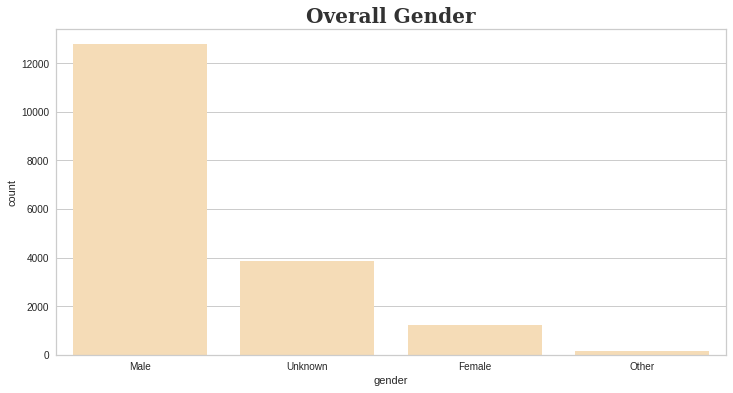

In [236]:
fig = plt.figure(figsize=(12,6))
plt.title('Overall Gender', fontsize=20, fontweight='bold', fontfamily='serif', color="#323232")
sns.countplot(x=df["gender"], color='navajowhite')
plt.show()

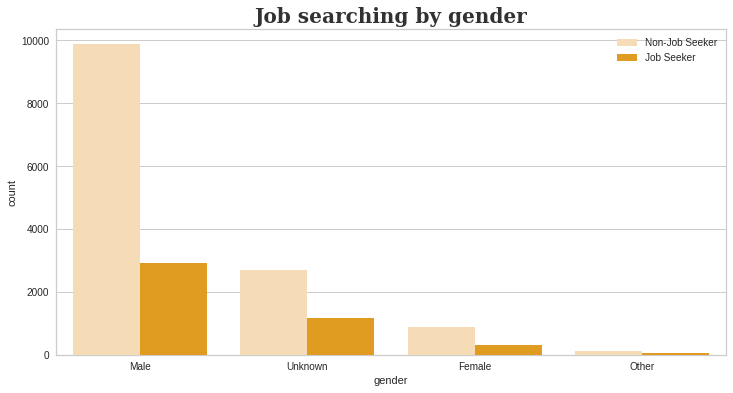

In [235]:
color_palette = ['navajowhite', 'orange']
fig = plt.figure(figsize=(12,6))
plt.title('Job searching by gender', fontsize=20, fontweight='bold', fontfamily='serif', color="#323232")
ax = sns.countplot(x="gender", hue="target", data=df, palette=color_palette, zorder=3)
ax.legend(["Non-Job Seeker", "Job Seeker"])
plt.show()

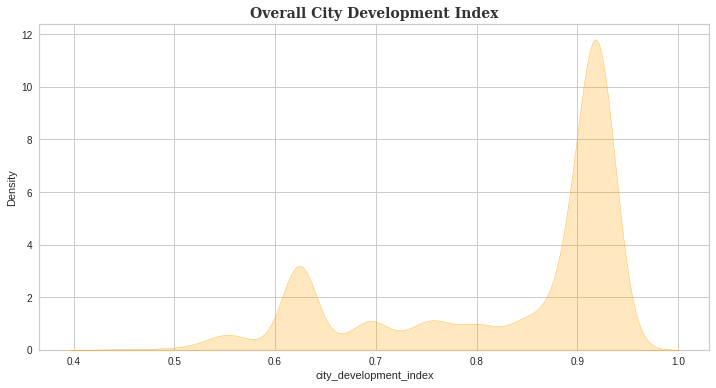

In [244]:
fig = plt.figure(figsize=(12,6))
plt.title('Overall City Development Index', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
sns.kdeplot(df["city_development_index"], color="orange", shade=True, zorder=3)
plt.show()

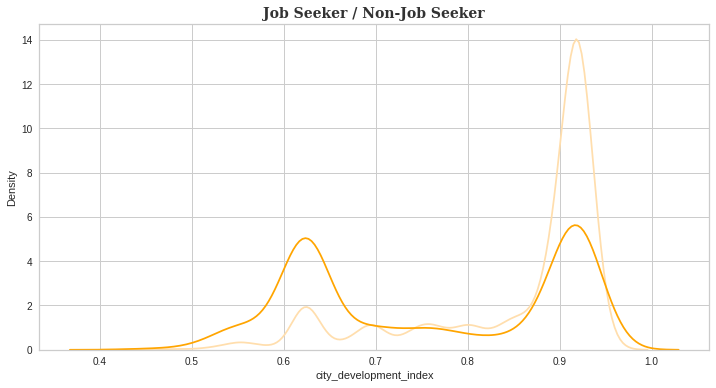

In [242]:
fig = plt.figure(figsize=(12,6))
plt.title('Job Seeker / Non-Job Seeker', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
sns.kdeplot(df.loc[(df["target"]==0), "city_development_index"], color="navajowhite", label="Not Survived")
sns.kdeplot(df.loc[(df["target"]==1), "city_development_index"], color="orange", label="Survived")
plt.show()